# MNIST

사이킷런에서 제공하는 여러 헬퍼 함수를 사용해 잘 알려진 데이셋 내려받을 수 있음.

In [1]:
import os
import matplotlib.pyplot as plt

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

읽어들인 데이터셋들은 일반적으로 dict 구조를 가지고 있음.

- 데이터셋을 설명하는 DESCR 키

- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키

- 레이블 배열을 담은 target 키

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


이미지는 7만 개가 있고 각 이미지에는 784개의 특성이 존재, 이미지가 28 X 28 픽셀이기때문

개개의 특성은 단순히 0(흰) ~ 255(검정) 까지의 픽셀의 강도를 나타냄.

그림 저장: some_digit_plot


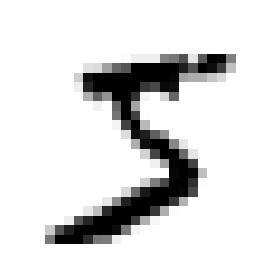

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

# 그림 안 나옴 !

In [5]:
y[0]

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기 훈련

문제를 단순화해 하나의 숫자 예를 들어 숫자 5만 식별해봅시다. '5-감지기' : 이진분류기

In [8]:
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

이제 분류모델을 하나 선택해 훈련시켜보겠습니다. 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사하강법 (SGD) 분류기로

시작해보는 것도 나쁘지 않습니다. 이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지님.

SGD가 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문.



- 어떤 경우 데이터셋을 섞지 않는 것이 좋음. 주식가격이나 날씨 예보같은 시계열 데이터를 다룰 때

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# SGDClassifier는 훈련하는데 무작위성을 사용합니다.(그래서 확률적이 붙음). 
# 결과를 재현하고 싶다면 random_state 매개변수 지정필요

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

- 교차검증을 사용한 정확도 측정

가끔 사이킷런이 제공하는 기능보다 교차검증과정을 더 많이 제어해야 할 필요가 있음.

이때는 교차검증을 직접 구현하면 됨. 다음코드는 cross_val_score() 함수와 거의 같은 작업을 수행.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행.

매 반복에서 분류기 객체를 복제해 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦

그런 다음 올바른 예측의 수를 세어 정확한 예측 비율 출력.

cross_val_score() 함수로 폴드가 3개인 k-겹 교차검증을 사용해 SGDClassifier 모델 평가

(여기서는 k는 3개)

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

정확도가 95퍼 이상임 ! -> 이번에는 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어봄

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)
      
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

정확도가 90퍼 이상으로 나옴. 이밎의 10퍼정도만 숫자 5이기에 무조건 '5아님'으로

예측하면 정확히 맞출 확률이 90퍼 입니다.

# 오차행렬 ***

분류기 성능 평가하는 더 좋은 방법은 오차 행렬 조사.

기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것.

예로 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고싶다면 오차 행렬의 5행 3열을 보면 됨.

우선 오차 행렬을 만들려면 실제 target과 비교할수 있도록 예측값을 만들어야함.

테스트 세트로 예측을 만들면 안 됨.(항상 출시 준비 마치고 프로젝트 맨 마지막에 사용된다는 것을 잊지 말 것)

대신 cross_val_predict 함수를 사용할 수 있음.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_score() 함수처럼 cross_val_predict() 함수는 k-겹 교차검증을 수행하지만

평가점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환. 즉 훈련 세트의 모든 샘플에 대해

깨끗한 예측을 얻게 됨. (여기서 '꺠끗한'의 의미는 모델이 훈련하는 동안 보지못했던 데이터에 대해 예측했다는 의미)

이제 오차행렬을 만들준비가 됨 [confusion_matrix() 함수를 사용해서].

타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출하면 됨

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- 오차행렬의 행 : 실제 클래스

- 오차행렬의 열 : 예측한 클래스

음성 클래스 > 53892개 -> 5 아님(진짜 음성) | 687개 -> 5 라고 잘못 분류(거짓 양성)

양성 클래스 > 1891개 -> 5 아님으로 잘못 분류(거짓 음성) | 3530개 -> 진짜 5(진짜 양성)

완벽한 분류기의 경우 오차 행렬의 주대각선만 0이 아닌 값이 됨.

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

더 요약된 지표

진짜양성 - TP, 거짓양성 - FP, 거짓음성 - FN

- 정밀도 : TP / (TP + FP)

- 재현율(민감도, 진짜 양성 비율) : TP / (TP + FN)

# 정밀도와 재현율

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

5로 판별된 이미지 중 83.7%만 정확함. 전체 숫자 5 에서 65.11%만 감지함.

정밀도와 재현율을 $F_1$ 점수라고 하는 하나의 숫자로 만들면 편리할 때가 많음.

$F_1$ = TP / (TP + (FN + FP) / 2) -> f1_score() 호출

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 $F_1$ 점수가 높음. - 하지만 항상 바람직한 것은 아님.

예를 들어 어린애에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정해봅시다.

재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도(낮은 재현율)

안전한 것들만 노출시키는(높은 정밀도) 분류기를 선호할 것임.

(이런 경우에는 분류기의 영상선택결과를 확인하기 위해 사람이 참여하는 분석 파이프라인을 추가할지도 모름)

다른 예시로 감시카메라로 좀도둑을 잡아내는 분류기를 훈련시킨다고 가정해봅시다.

분류기의 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을지 모릅니다.

(아마도 경비원이 잘못된 호출을 종종 받게 되겠지만, 거의 모든 좀도둑을 잡을 것임.)

-> 정밀도와 재현율은 서로 반비례 관계임.

# 정밀도/재현율 트레이드오프

이 SGDClassifier로 트레이드오프의 원리를 살펴봅시다.

이 분류기는 결정함수를 사용해 각 샘플의 점수를 계산함.

이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않다면 음성 클래스에 할당.

그림 homl03-03.png 참고

사이킷런에서 임곗값을 직접 지정할 수는 없으나 예측에 사용한 점수는 확인할 수 있음.

decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있음.

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SGDClassifier의 임곗값이 0 이므로 위 코드는 predict() 와 같은 결과를 반환함

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

이 결과로 임곗값을 높이면 재현율이 줄어든다는 것을 보여줌.

이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 8000으로 높이면

이를 놓침. 어떻게 적절한 임곗값을 세팅하냐? 

-> 모든 샘플의 점수를 구해야함. 이번에는 예측 결과가 아닌 결정점수를 반환받도록 지정 (with. cross_val_predict)

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

해당 점수로 precision_recall_curve()를 사용해 가능한 모든 임곗값에 대해 정밀도와 재현율 계산가능

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


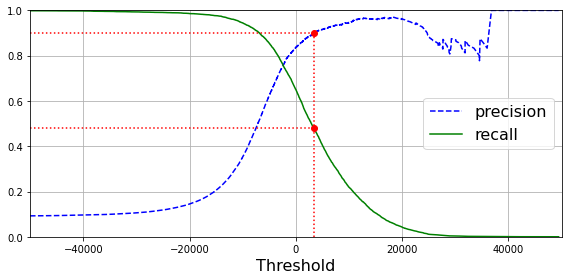

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--",label="precision")
  plt.plot(thresholds, recalls[:-1], "g-",label="recall")
  plt.legend(loc="center right", fontsize=16) # 범례표시 - precision, recall
  plt.xlabel("Threshold", fontsize=16)        # X축 레이블 - Threshold
  plt.grid(True)                              # 격자무늬, 데이터 위치 더 자세히보여주는 회색선
  plt.axis([-50000, 50000, 0, 1])             # 축 범위
  
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# r: => 붉은색 마커 + 실선
# ro => 붉은색 원형 마커  
plt.figure(figsize=(8, 4))                                                                    # 그래프가 그려질 바탕 생성
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  # 붉은 점에 X축에 수직인 붉은 점선
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                 # 정밀도 위 붉은 점에 Y축에 수직인 붉은 점선
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")  # 정밀도 위 붉은 점에 Y축에 수직인 붉은 점선
plt.plot([threshold_90_precision], [0.9], "ro")                                               # 정밀도선 위 붉은 점
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                               # 재현율선 위 붉은 점
save_fig("precision_recall_vs_threshold_plot")                                                # 그림 저장 함수 맨 위에
plt.show()
  

그림 저장: precision_vs_recall_plot


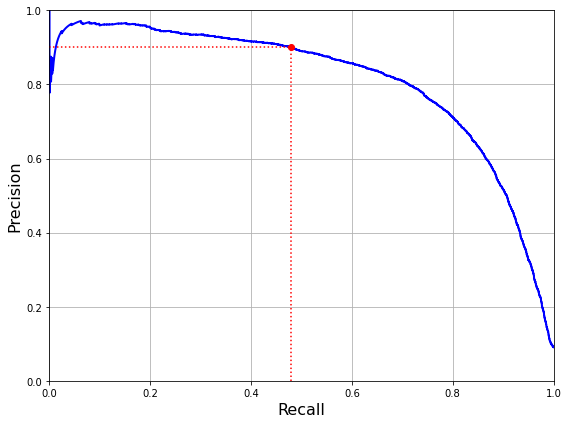

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

위 그림에서 정밀도 곡선이 재현율 곡선보다 왜 더 울퉁불퉁한지 의아할 수 있음.

이는 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문 (일반적으로는 높아져야 함.)

그림 homl03-03.png 다시보면 가운데 임곗값에서 오른쪽으로 숫자 하나만큼 이동하면

정밀도는 4/5(80%) 에서 3/4(75%)로 줄어듦. 반면 재현율은 임곗값이 올라감에 따라 줄어들 수 밖에 없어

위 그래프처럼 부드러운 곡선이 됨

재현율 80% 근처에서 정밀도가 급격히 줄어듦. 이 하강점 직전을 정밀도/재현율 트레이트오프로

선택하는 것이 좋음. 예를 들어 재현율 60% 정도인 지점. 물론 프로젝트에 따라 다름

만약 정밀도 90%를 달성하는 것이 목표라면 위 그래프에서 임곗값이 약 8000정도 됨.

좀 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있음.

(np.argmax()는 최댓값의 첫 번째 인덱스를 반환함. 여기서는 첫번째 True 값을 의미)

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

훈련 세트에 대한 예측을 만들려면 분류기의 predict() 대신 다음코드를 실행

In [28]:
y_trian_pred_90 = (y_scores >= threshold_90_precision) # 이 예측에 대한 정밀도와 재현율 확인

In [29]:
precision_score(y_train_5, y_trian_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_trian_pred_90)

0.4799852425751706

충분히 큰 임곗값을 지정함으로써 분류기를 쉽게 만들수 있음. 

!!! 하지만, 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 좋지 못함.

# ROC 곡선

수신기 조작 특성 (ROC) 곡선도 이진 분류에서 널리 사용하는 도구

거짓양성비율(FPR) 에 대한 진짜양성비율(TPR)의 곡선임.

또는 민감도(재현율)에 대한 1-특이도 그래프.

FPR(거짓양성비율) = 1 - TNR(진짜음성비율)

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


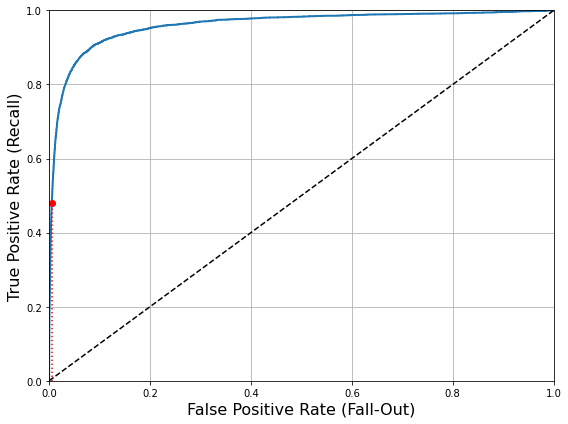

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

여기에도 트레이드오프가 존재. 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻함.

좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함.

곡선 아래 면적(AUC)을 측정하면 분류기를 비교가능함.

완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5임

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

PR(정밀도/재현율) 곡선과 ROC(수신기 조작 특성) 곡선이 비슷해서 어떤 곡선을 사용해야할지 고민되는 경우가 있는데

일반적으로 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR곡선을 사용함.

그렇지 않다면 ROC 곡선 사용.

예로 ROC곡선을 보면 매우 좋은 분류기라고 생각할 수 있는데, 허나 이는 음성(5 아님)에 비해 양성(5)이 크게 적기 때문

이와 달리 PR곡선은 분류기의 성능개선여지가 얼마나 되는지(오른쪽 위 모서리에 가까워질 수 있는지) 잘 보여줌.

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 ROC AUC 점수를 비교해보겠습니다.

먼저 훈련세트의 샘플에 대한 점수를 얻어야 함. 하지만 작동방식의 차이 때문에 decision_function()이 없음.

대신 predict_preba()가 있음. 해당 함수는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에

속한 확률을 담은 배열을 반환함.

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

roc_curve() 함수는 레이블과 점수를 기대함. 허나 점수대신 클래스 확률을 전달

In [35]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

그림 저장: roc_curve_comparison_plot


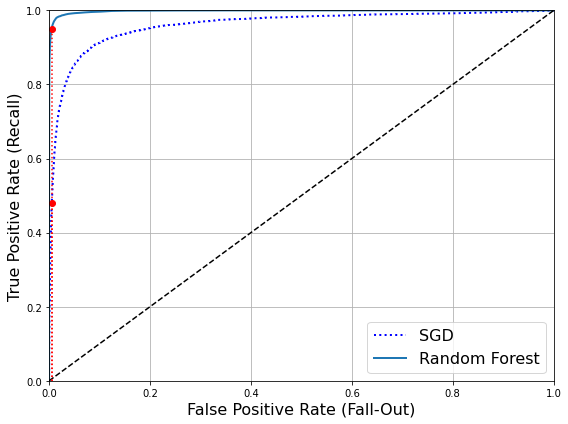

In [36]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

랜덤포레스트 분류기가 SGD분류기보다 훨씬 좋음. 랜덤 포레스트의 ROC 곡선이 왼쪽 위 모서리에 더 가깝기 때문

In [37]:
roc_auc_score(y_train_5, y_scores_forest) # 정밀도

0.9983436731328145

In [38]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [39]:
recall_score(y_train_5, y_train_pred_forest) # 재현율

0.8662608374838591

# 다중 분류

일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, 다른 알고리즘은 이진 분류만 가능

하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음.

예로 OvR(또는 OvA)는 특정 수 하나만 구분하는 숫자별 이진 분류가 10개(0~9)를 훈련시켜

클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있음.

|

다른 전략으로 OvO는 0과 1 구별, 0과 2 구별, 1과 2구별 등과 같이 각 숫자의 조합마다

이진 분류기를 훈련 시킴. 클래스가 N개 라면 분류기는 n(n-1)/2개가 필요.

-> 이 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 2 클래스에 해당하는 샘플만 필요

|

일부는 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다

작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호하고 대부분 이진분류 알고리즘은

OvR 선호

In [40]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

위 코드는 5를 구별한 타깃 클래스(y_train_5) 대신 0~9까지의 원래 타깃클래스(y_train)를 사용해

SVC 훈련시킴. 그런 다음 예측 하나를 만듦. 내부에선 OvO 전략을 사용해 45개의 이진분류기를

훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택

실제로 그런지 decision_function()를 호출해 확인해봅시다. (샘플당 10개의 점수 반환)

이 점수는 클래스마다 하나씩임

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores # 가장 높은 점수가 클래스 5에 해당하는 값

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [42]:
np.argmax(some_digit_scores)

5

In [43]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
svm_clf.classes_[5]

5

분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장

위의 예제에서는 classes_ 배열에 있는 각 클래스의 인덱스가 클래스 값 자체와 같음.

(즉, 인덱스 5에 해당하는 클래스의 값은 5입니다.) 하지만 일반적으로 이런 경우는 드뭅니다

사이킷런에서 OvO나 OvR 사용을 강제하려면 OneVsRestClassifier나 OneVsOneClassifier를 사용함.

In [45]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
len(ovr_clf.estimators_)

10

SGDClassifier나 RandomForestClassifier를 훈련시키는 것도 간단

In [47]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로

사이킷런의 OvR이나 OvO를 적용할 필요가 없음. decision_function()는 클래스마다

하나의 값을 반환함. SGD 분류기가 클래스마다 부여한 점수를 확인해봅시다.

In [48]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

이 결과에서 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있음.

대부분의 점수가 큰 음수. 반면 클래스 5의 점수는 음수네? -> 학습된 듯?

이 모델은 클래스 3을 조금 의심하고 있음.

이 분류기를 cross_val_score()를 사용해 SGDClassifier의 정확도를 평가해봅시다.

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

모든 테스트에서 %이상 얻음. 랜덤 분류기를 사용했다면 10% 정확도를 얻었을 것이므로

이 점수가 아주 나쁘지는 않지만 성능을 더 높일 여지가 있음.

예를 들어 간단하게 입력 스케일을 조정하면 (2장처럼) 정확도를 89% 이상으로 높일 수 있음.

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 에러 분석

실제 프로젝트라면 머신러닝 프로젝트 체크리스트(부록 B)의 단계를 따를 것임.

데이터 준비 단계에서 가능한 선택 사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라

GridSearchCV를 사용해 하이퍼파라미터를 세밀히 튜닝하고, 앞 장에서 한 것처럼 가능한 한 자동화함.

이번에는 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾겠습니다.

한 가지 방법은 만들어진 에러의 종류를 분석하는 것. 먼저 오차 행렬을 살펴볼 수 있음.

cross_val_predict()를 사용해 예측을 만들고 이전처럼 confusion_matrix() 호출

In [51]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

많은 수가 출력됨. 오차 행렬을 matplotlib의 matshow()를 사용해 이미지로 표현하면 보기에 편리함.

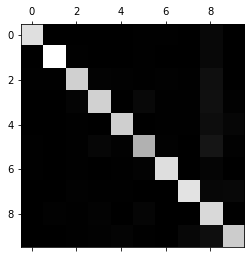

In [52]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

이 오차행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아보임.

숫자 5는 다른 숫자들보다 좀 더 어워보임. 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 

숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻. 사실 두 경우 모두 확인해야봐야 함.

|

그래프의 에러 부분에 초점을 맞춰, 먼저 오차행렬의 각 값을 대응되는 클래스의 이미지 수로

나누어(에러의 절대 개수가 아닌) 에러 비율을 비교함 (개수로 비교하면 이미지가 많은 클래스가

상대적으로 나쁘게 보임)

In [53]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그림.

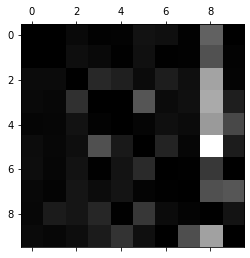

In [54]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

여기서 분류기가 만든 에러를 확실히 볼 수 있음.

행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다는 사실을 기억하십시오.

-> 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시

|

하지만 클래스 8의 행은 그리 나쁘지 않음. 이는 실제 8이 적절히 8로 분류되었다는 것

여기서 볼 수 있듯이 오차 행렬은 반드시 대칭은 아님. 3과 5가 서로 많이 혼동되고 있는 것도 볼 수 있음.

|

오차 행렬을 분석하면 분류기 성능 향상 방안에 대한 통찰을 얻을 수 있음.

그래프를 살펴보면 8로 잘못 분류된 것을 줄이도록 개선할 필요가 있음.

예를 들어 8처럼 보이는 숫자의 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습시킴.

또는 분류기에 도움 될 특성을 더 찾을 수 있음. 동심원의 수를 세는 알고리즘 같은 것.

또는 동심원 같은 어떤 패턴이 드러나도록 이미지 전처리를 할 수도 있음.

개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대해 통찰을

얻을 수 있지만, 더 어렵고 시간이 걸림. 예로 3과 5 샘플을 그려보겠습니다.

(plot_digits()는 단순히 맷플롭립의 imshow()를 사용하는 함수, 자세한 내용은 주피터노트북 살펴볼 것)

In [55]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: error_analysis_digits_plot


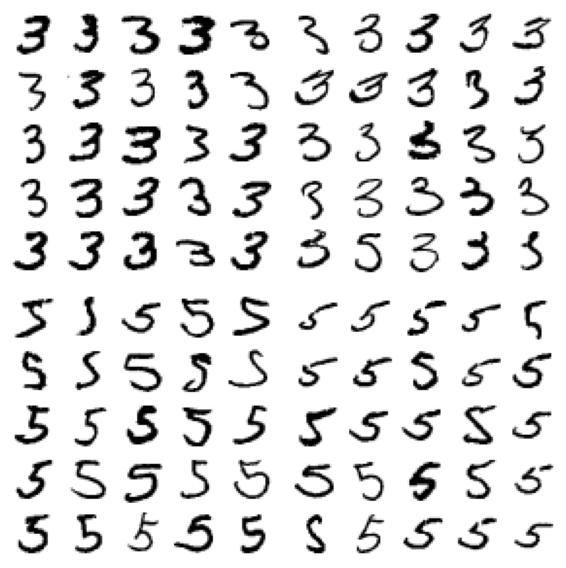

In [56]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

왼쪽의 5 * 5 블록 2개는 3으로 분류된 이미지고 오른쪽 5 * 5 블록 2개는 5로 분류된 이미지.

분류기가 잘못 분류한 숫자 중 일부는 정말 잘못 쓰여 있어서 (왼쪽 아래 블록과 오른쪽 위 블록)

|

그러나 대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고 분류기가 실수한 이유를 이해하기 어려움.

원인은 선형 모델인 SGDClassifier를 사용했기 때문, 선형 분류기는 클래스마다 픽셀에 가중치를 

할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스 점수로 계산

-> 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동.

3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치.

숫자 3을 쓸 때 연결 부위가 조금 왼쪽으로 치우쳐지면 분류기가 5로 분류하고, 반대도 마찬가지

다른 말로 분류기는 이미지의 위치나 회전 방향에 매우 민감. 

|

3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것

# 다중 레이블 분류

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

이 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 y_multilabel 배열을 만듦

첫 번째는 숫자가 큰 값 (7,8,9)인지 나타내고 두 번째는 홀수를 나타냄.

그 다음 줄이 KNeighborsClassifier 인스턴스를 만들고 다중 타깃 배열을 사용해 훈련.

(KNeighborsClassifier는 다중 레이블 분류를 지원하지만 모든 분류기가 그런 것은 아님.)

In [58]:
knn_clf.predict([some_digit]) # 예측을 만들면 레이블이 2개 출력

array([[False,  True]])

숫자 5는 크지 않고(False) 홀수(True).

|

다중 레이블 분류기를 평가하는 방법은 많음. 적절한 지표는 프로젝트에 따라 다름.

예로 $F_1$ 점수를 구하고 간단하게 평균 점수를 계산.

다음 코드는 모든 레이블에 대한 $F_1$ 점수의 평균을 계산

In [59]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

실제로는 아닐 수 있으나 이 코드는 모든 레이블의 가중치가 같다고 가정

특히 앨리스 사진이 밥이나 찰리 사진보다 훨씬 많다면 앨리스 사진에 대한 분류기의 점수에

더 높은 가중치를 둘 것. 간단한 방법은 레이블에 클래스 지지도(

즉, 타깃 레이블에 속한 샘플 수)를 가중치로 주는 것

-> 이렇게 하려면 이전 코드에서 average="weighted"로 설정

# 다중 출력 분류

In [60]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_example_plot


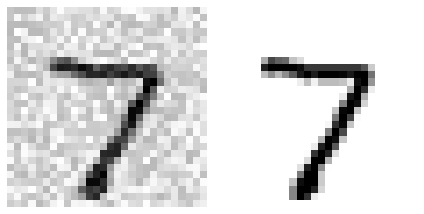

In [62]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show() # ??? 오류

그림 저장: cleaned_digit_example_plot


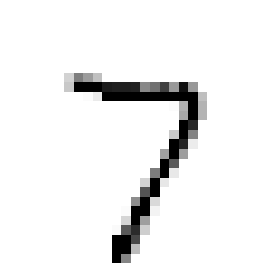

In [63]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

## 1. 97% 정확도의 MNIST 분류기

 # 하이퍼파라미터 값 설정을 어떻게 해야하나? ***

하이퍼파리마터 값들은 인터넷에 검색하면 나오는데 예시로

"KNeighborsClassifier parameters" 라고 하던가 아니면 "KNeighborsClassifier 파라미터" 라고 검색, 

Runebook.dev 라는 곳에서 모든 파라미터들을 설명해줌. 대부분 파라미터별 범위도 알려줌.

|

class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs) 

이런 형태로 나오게 되는데 기본적으로 가능한 값들을 나열해줌. 그냥 숫자형으로 나왔는데 범위가 안 나오는 

매개변수(하이퍼파라미터)는 그냥 default 값에 ±n 해주면 됨.

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3,4,5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3) # verbose 는 수행 결과 메세지 출력, cv는 반복 횟수
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  17.9s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  18.6s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  18.3s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  17.9s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  18.3s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  18.0s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  18.3s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  18.3s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  17.8s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  18.1s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  21.2s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [65]:
print('[-] Best Params :', grid_search.best_params_)

[-] Best Params : {'n_neighbors': 4, 'weights': 'distance'}


In [66]:
print('[-] Best Score :', grid_search.best_score_)

[-] Best Score : 0.9716166666666666


In [67]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
print("[+] Accuracy :", accuracy_score(y_test, y_pred))

[+] Accuracy : 0.9714


## 2. 데이터 증식

In [68]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

subplot 함수는 css의 그리드 객체와 비슷한 형태임

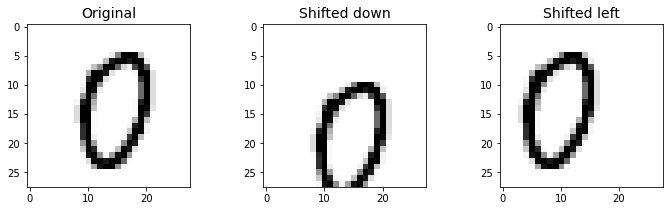

In [69]:
image = X_train[1000]                           # 1000번째 훈련 항목
shifted_image_down = shift_image(image, 0, 5)   # 5픽셀 아래로 움직임
shifted_image_left = shift_image(image, -5, 0)  # 5픽셀 왼쪽으로 움직임

plt.figure(figsize=(12, 3))                     # 그래프 바탕 생성
plt.subplot(131)                                # 1행 3열 1번째 부분에 객체 생성
plt.title("Original", fontsize=14)              # 그래프 - Original
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)                                                          # 1행 3열 2번째 부분에 객체 생성
plt.title("Shifted down", fontsize=14)                                    # 그래프 - Shifted down
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)                                                          # 1행 3열 3번째 부분에 객체 생성
plt.title("Shifted left", fontsize=14)                                    # 그래프 - Shifted left
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")  
plt.show()

# imshow(title, image) - 기본적으로 2차원 행렬임, interpolation은 이미지 확대 및 축소를 함.

In [70]:
X_train_augmented = [image for image in X_train]    # 이미지를 리스트에 담음
y_train_augmented = [label for label in y_train]    # 이미지를 리스트에 담음

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):   # x,y 값을 각각 ±1을 순회함
    for image, label in zip(X_train, y_train):      # 걱 이미지마다 ±1px 하면서 순회함
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)             # 레이블은 픽셀을 움직일 필요없음

X_train_augmented = np.array(X_train_augmented)     # 배열 생성
y_train_augmented = np.array(y_train_augmented)     # 배열 생성

In [71]:
shuffle_idx = np.random.permutation(len(X_train_augmented))   # 행렬 섞은 인덱스 값
X_train_augmented = X_train_augmented[shuffle_idx]            # 랜덤 값 X_train
y_train_augmented = y_train_augmented[shuffle_idx]            # 랜덤 값 y_train

knn_clf = KNeighborsClassifier(**grid_search.best_params_)    # 최적의 파라미터 적용

knn_clf.fit(X_train_augmented, y_train_augmented)             # 모델 생성

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [72]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763